# Hello World

In [4]:
print("Hello World");

Hello World


In [3]:
#to display images inline and not at end of notebook
%matplotlib inline 
#other imports
import numpy as np
import PIL #Python image library
import matplotlib.pyplot as plt #matlab-like way of plotting 
from scipy import ndimage #importing ndimage so we can do multi-dimensional processing
import imageio
from scipy import misc #scipy is image processing lib get miscelaneaou module
import glob
import sys


In [41]:
#f = misc.face(); #face of a raccoon offered my misc module
#img = imageio.imread('imageio:astronaut.png')
# afroImg = imageio.imread('/home/pascal/computer_graphics/santa-fung-afro-007.jpg')
afroImg = imageio.imread('/home/pascal/computer_graphics/santa-fung-afro-007.jpg')
print(afroImg.shape)
#imageio.imwrite('face.png', f);

(1252, 1800, 3)


In [5]:
# TODO: create genereic homogenize function for any size matrix
def homogenize3(m) : 
    hom = np.array([
                   [m[0][0], m[1][0], m[2][0]],
                   [m[3][0], m[4][0], m[5][0]],
                   [0, 0, 1]
                   ])
    return hom 

In [53]:
def estimateAffine(X, X_prime) :
    M = np.array([
                [X[0][0], X[0][1], 1, 0, 0, 0], 
                [0, 0, 0, X[0][0], X[0][1], 1],
                [X[1][0], X[1][1], 1, 0, 0, 0],
                [0, 0, 0, X[1][0], X[1][1], 1],
                [X[2][0], X[2][1], 1, 0, 0, 0],
                [0, 0, 0, X[2][0], X[2][1], 1]
                ]) #Source matrix represneted with 3 points homogenously (eq.7)
    # b = np.array([X_prime[0][0], X_prime[0][1], X_prime[1][0], X_prime[1][1], X_prime[2][0], X_prime[2][1]])
    b = np.array([[X_prime[0][0]], 
                 [X_prime[0][1]], 
                 [X_prime[1][0]], 
                 [X_prime[1][1]], 
                 [X_prime[2][0]], 
                 [X_prime[2][1]]]) #Destination matrix as a column vector
    print(M)
    print(b)
    M_inv = np.linalg.inv(M) #Computer inverse of M matrix
    M_id = np.dot(M, M_inv) #M identity matrix
    print(M_id) #Verifying that I get an identity matrix
    I = np.identity(6)
    print(np.identity(6))
    a = np.dot(M_inv, b) #Compute transformation coefficients
    print("Transformation coefficients: ")
    print(a)
    a = homogenize3(a)
    return a

    # Attempt to make sure that inverse result is accurate
    # by comparing M identity to perfect identiy matrix (currently not working)
    # if np.allclose(M,I,1,1) :
    #     print('Good identity')
    # else:
    #     print('Bad identity')

In [54]:
def getDstImageSize(X_prime) :
    s = X_prime.shape
    print(s)
    x_s = X_prime[:,0] #All of first col (x's)
    y_s = X_prime[:,1] #All of second col (y's)
    x_min = np.amin(x_s)
    x_max = np.amax(x_s)
    y_min = np.amin(y_s)
    y_max = np.amax(y_s)
    n_rows = y_max - y_min #compute min # of rows to contain dst image
    n_cols = x_max - x_min #compute min # of cols to contain dst image
    return n_rows, n_cols


In [98]:
def isWithinBoundaries(x, y, nCols, nRows):
    # Return True if (x,y) is within the boundaries of matrix A(nRows,nCols)
    return (x>=0 and x<nRows and y >= 0 and y < nCols)

In [50]:
def verifyDstImg(dstImg, img):
    srcRedVals = open('srcRedVals.txt', 'w')
    print(img[:,:,0], file=srcRedVals) #Only get the first later of RGB (R)
    srcRedVals.close()
    imgFirstRed = img[0,0,0]
    dstImgFirstRed = dstImg[0,0,0]
    imgR_inv = np.linalg.inv(imgFirstRed)
    A = np.dot(imgR_inv, dstImgR)
    print(A)
    

In [93]:
def inverseTransformation(u, v, A_inv):
    dstMatrx = np.array([[v], 
                         [u], 
                         [1]
                        ])
    srcHmgMtrx = np.dot(A_inv, dstMatrx) #This matrix will be homogeneous
    srcMtrx = np.array([srcHmgMtrx[0][0], srcHmgMtrx[1][0]]) # get rid of the 1 and make it 2d vector
    x = int(srcMtrx[0])
    y = int(srcMtrx[1])
    return x,y

In [103]:
def inverseMapping(A, X, X_prime, img) :
    n_rows, n_cols = getDstImageSize(X_prime) #Compute minimum size of destination image from destination triangle 
    srcImgRows = img.shape[0]
    srcImgCols = img.shape[1]
    dstImg = np.zeros((srcImgRows, srcImgCols, 3))
    # dstImg = np.zeros((n_rows, n_cols, 3), dtype='f')
    print('Dest image shape: ')
    print(dstImg.shape)
    print('Inverse of transformation matrix: ')
    A_inv = np.linalg.inv(A)
    print(A_inv)
    print(img.shape)
    # outputHmg = open('outputHmg.txt', 'w')
    # outputMtrx = open('outputMtrx.txt', 'w')
    print(srcImgRows)
    print(srcImgCols)
   
    for i in range(0, srcImgRows) :
        for j in range(0, srcImgCols):
            #On 2nd interation, u=1 and v = 0 of position (1,0) on image
            x,y = inverseTransformation(i,j,A_inv)
            if isWithinBoundaries(x, y, srcImgCols, srcImgRows):
                dstImg[i, j, 0] = img[x, y, 0] 
                dstImg[i, j, 1] = img[x, y, 1]
                dstImg[i, j, 2] = img[x, y, 2]
    # outputHmg.close()
    dstImg = 255 - dstImg # I am not entirely sure why I have to do this, but if I don't it will paint the negative of the transormed image
    verifyDstImg(dstImg, img)
    return dstImg

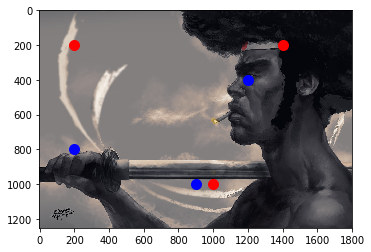

[[ 200  200    1    0    0    0]
 [   0    0    0  200  200    1]
 [1400  200    1    0    0    0]
 [   0    0    0 1400  200    1]
 [1000 1000    1    0    0    0]
 [   0    0    0 1000 1000    1]]
[[ 200]
 [ 800]
 [1200]
 [ 400]
 [ 900]
 [1000]]
[[ 1.00000000e+00  0.00000000e+00  4.25007252e-17  0.00000000e+00
  -5.55111512e-17  0.00000000e+00]
 [ 0.00000000e+00  1.00000000e+00  0.00000000e+00  4.25007252e-17
   0.00000000e+00 -5.55111512e-17]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  1.82145965e-17  0.00000000e+00
   1.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.82145965e-17
   0.00000000e+00  1.00000000e+00]]
[[1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 1.]]
Transformation coe

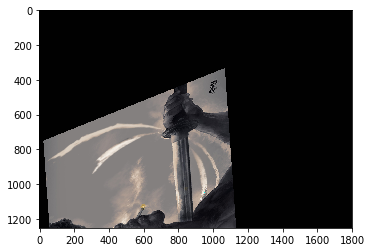

In [104]:
plt.figure();
plt.imshow(afroImg);
# Source triangle
plt.scatter(200, 200, s=100, c='red', marker='o');
plt.scatter(1400, 200, s=100, c="red", marker="o");
plt.scatter(1000, 1000, s=100, c="red", marker="o");
X = np.array([[200, 200], 
              [1400, 200], 
              [1000, 1000]
              ]);

#Destination triangle
class dstTri :
    class p1 :
        x = 200
        y = 800
    class p2 :
        x = 1200
        y = 400
    class p3 :
        x = 900
        y = 1000
#Transform #2
# class dstTri :
#     class p1 :
#         x = 600
#         y = 400
#     class p2 :
#         x = 1200
#         y = 400
#     class p3 :
#         x = 900
#         y = 1000
#Transform #3 (Requires a larger size than source image to disaplay)
# class dstTri :
#     class p1 :
#         x = 400
#         y = 200
#     class p2 :
#         x = 1300
#         y = 800
#     class p3 :
#         x = 400
#         y = 800
    
plt.scatter(dstTri.p1.x,dstTri.p1.y, s=100, c='blue', marker='o');
plt.scatter(dstTri.p2.x, dstTri.p2.y, s=100, c="blue", marker="o");
plt.scatter(dstTri.p3.x, dstTri.p3.y, s=100, c="blue", marker="o");

X_prime = np.array([[dstTri.p1.x, dstTri.p1.y], 
                    [dstTri.p2.x, dstTri.p2.y], 
                    [dstTri.p3.x, dstTri.p3.y]]);

plt.show();
A = estimateAffine(X, X_prime);
print('Transformation matrix: ')
print(A)
dstImg = inverseMapping(A, X, X_prime, afroImg)
# plt.figure(figsize = (10,10))
# plt.imshow(dstImg, interpolation='nearest', aspect='auto')
plt.imshow(dstImg)